# Autoencoder

Датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан в файле get_dataset.py


## Prepare the data

In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import torchvision
from time import sleep
from IPython.display import Image, clear_output

%matplotlib inline

In [0]:
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

Размер картинок.

In [41]:
data[0].shape

(52, 52, 3)

In [0]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
X_train, X_val = torch.utils.data.random_split(data, [TRAIN_SIZE, VAL_SIZE])

In [0]:
X_train = torch.autograd.Variable(torch.FloatTensor(X_train))
X_val = torch.autograd.Variable(torch.FloatTensor(X_val))

In [0]:
X_train = X_train / 255
X_val = X_val / 255

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

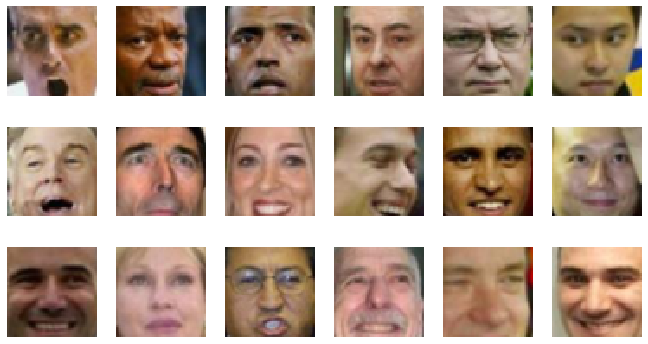

In [8]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

# Autoencoder


<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [0]:
inp_size=X_train.shape[1]
hid_size1=256
hid_size2 = 128
dimZ = 128

Encoder возвращает латентный вектор картинки.

In [0]:
class Encoder(nn.Module):
    def __init__(self):
      super(Encoder, self).__init__()
      self.input = nn.Sequential(
          nn.Linear(inp_size * inp_size * 3, 2028),
          nn.ELU(True)) 
      
      
      self.encoder = nn.Sequential(
          nn.Conv2d(3, hid_size1, 3, stride=3, padding=1),  
          nn.ELU(True),
          
          nn.Conv2d(hid_size1, hid_size2, 3, stride=2, padding=1),
          nn.ELU(True),
          
      )
      
      self.code = nn.Sequential(
          nn.Linear(3200, dimZ),
          nn.ELU(True)
      )
      
      
    def forward(self, x):
      x =  self.input(x)
      x = x.reshape(x.shape[0], 3, 26, 26)
      #print(0, x.shape)
      x = self.encoder(x)
      #print(1, x.shape)
      x = x.reshape(x.shape[0], -1)
      #print(2, x.shape)
      latent_code = self.code(x)
      
      return latent_code

Decoder принимает латентный вектор, восстаначливает картику и возвращает ее реконструкцию.

In [0]:
class Decoder(nn.Module):
    def __init__(self):
      super(Decoder, self).__init__()
      self.fc = nn.Sequential(
          nn.Linear(dimZ, 3200),
          nn.ELU(True),
      )
      
      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(hid_size2, hid_size1, 3, stride=2), 
          nn.ELU(True),
          nn.ConvTranspose2d(hid_size1, 3, 3, stride=3, padding=1),
          nn.ELU(True),
      )      
      self.out = nn.Sequential(
          nn.Linear(3*31*31, inp_size * inp_size * 3), 
          nn.Sigmoid()
      )
      
    def forward(self, x):
      
      x = self.fc(x)
      #print(4, x.shape)
      x = x.reshape(x.shape[0], 128, 5, 5)
      #print(5, x.shape)
      x = self.decoder(x)
      #print(6, x.shape)
      x = x.reshape(x.shape[0], 3*31*31)
      reconstruction = self.out(x)
      return reconstruction

Класс Autoencoder состоит из 2х объектов классов Encoder и Decoder.

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()
      self.encoder = Encoder()   
      self.decoder = Decoder()
      
    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)
      return reconstruction, latent_code

In [0]:
criterion = torch.nn.MSELoss(size_average=False)

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

In [14]:
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input): Sequential(
      (0): Linear(in_features=8112, out_features=2028, bias=True)
      (1): ELU(alpha=True)
    )
    (encoder): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (1): ELU(alpha=True)
      (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ELU(alpha=True)
    )
    (code): Sequential(
      (0): Linear(in_features=3200, out_features=128, bias=True)
      (1): ELU(alpha=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=3200, bias=True)
      (1): ELU(alpha=True)
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): ELU(alpha=True)
      (2): ConvTranspose2d(256, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (3): ELU(alpha=True)
    )
    (out): Sequential(
      (0): Linear(in_features=2883, out_features=8112, bias=Tr

In [0]:
X_train = X_train.reshape((X_train.shape[0], -1))


In [16]:
X_train.shape

torch.Size([10000, 8112])

In [0]:
X_val = X_val.reshape((X_val.shape[0], -1))

In [18]:
X_val.shape

torch.Size([3143, 8112])

Функция для генерации батчей.

In [0]:
def generate_batches(X, batch_size=64):
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        yield X_batch

Обучение автоэнкодера. Раз в 3 эпохи выводятся графики лоссов и реконсрукция картинки.

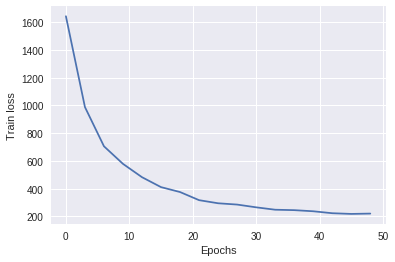

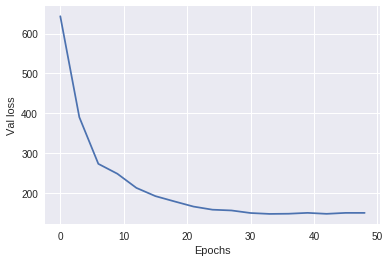

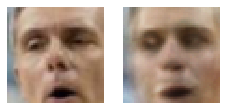

epoch 48
epoch 49
loss train	loss val
1642.7546	643.5551
988.2639	390.3953
705.6395	273.2718
578.8535	248.4305
482.7744	212.9252
411.2567	192.2884
375.8165	179.0179
317.2883	166.1094
294.9356	158.2587
285.5653	156.3139
265.7188	149.9444
248.4687	147.6510
245.3346	148.1298
237.3005	150.2905
223.2487	147.8581
218.1987	150.2530
220.6131	150.2289


In [20]:
BATCH_SIZE = 16
NUM_EPOCHS = 50

losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print('epoch', epoch)
    for X_batch in generate_batches(X_train, BATCH_SIZE):
      
      optimizer.zero_grad()
      
      out, _ = autoencoder(X_batch)
        
      loss = criterion(out, X_batch)
    
      loss.backward()
    
      optimizer.step()
   
    
    if epoch % 3 == 0:
      for X_val_batch in generate_batches(X_val, BATCH_SIZE):
        autoencoder.eval()
        out_val, code = autoencoder(X_val_batch)
        loss_val = criterion(out_val, X_val_batch)
        
      losses.append(loss.data.numpy())
      val_losses.append(loss_val.data.numpy())
        
      autoencoder.train()
      clear_output(wait=True)
      sleep(0.05)
      epochs = [i*3 for i in range(len(losses))]
      plt.plot(epochs, losses)
      plt.xlabel("Epochs")
      plt.ylabel("Train loss")
      plt.show()
      epochs = [i*3 for i in range(len(val_losses))]
      plt.plot(epochs, val_losses)
      plt.xlabel("Epochs")
      plt.ylabel("Val loss")
      plt.show()
        
      out_val = torch.autograd.Variable(torch.FloatTensor(out_val))
      plot_gallery([X_val_batch[0], out_val[0]], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
      plt.show()       
        
      print('epoch', epoch)
    
print('loss train\tloss val')
for i in range(len(losses)):
    print('%.4f\t%.4f' % (losses[i], val_losses[i]))

Проверяем как тренированный автоэнкодер кодирует и восстанавливает картинки:

In [0]:
x = 10
out_val, code = autoencoder(X_val[:x])

In [0]:
out_val = torch.autograd.Variable(torch.FloatTensor(out_val))

In [45]:
out_val.shape

torch.Size([10, 8112])

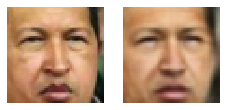

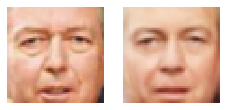

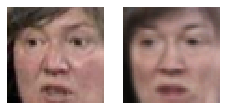

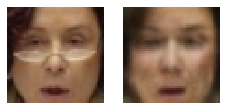

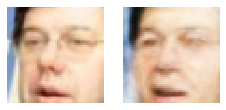

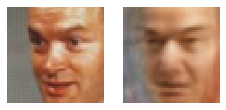

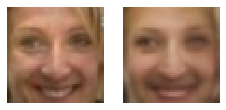

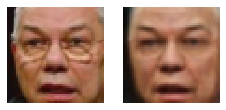

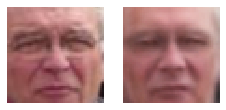

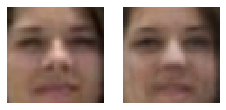

In [24]:
for i in range(x):
  
  plot_gallery([X_val[i], out_val[i]], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

# Sampling

Cгенерируем 25 рандомных векторов и подадим на вход декодеру вместо латентных векторов.
Посмотрим на результат реконструкции декодера:

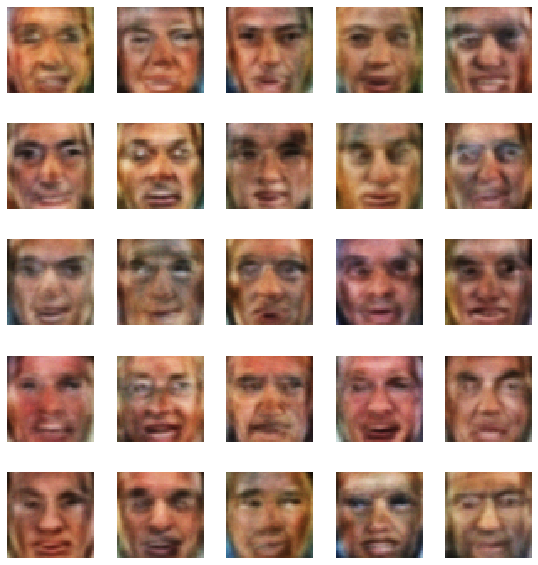

In [44]:
z = np.random.randn(25, dimZ)
z = torch.autograd.Variable(torch.FloatTensor(z*0.666))

output = autoencoder.decoder(z)
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

(почти нестрашно ._.)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

Находим в датасете несколько радостных и столько же уставших от этого бренного мира человеков.

In [0]:
smile = [1, 3, 5, 9,34, 58, 60, 83, 
         88, 96, 108, 132, 135, 138, 142, 146, 159, 184, 778, 786]

In [27]:
smiles=[]
for i in smile:
  smiles.append(data[i])


smiles = torch.autograd.Variable(torch.FloatTensor(smiles)) / 255 
smiles = smiles.reshape(smiles.shape[0], -1)
smiles.shape

torch.Size([20, 8112])

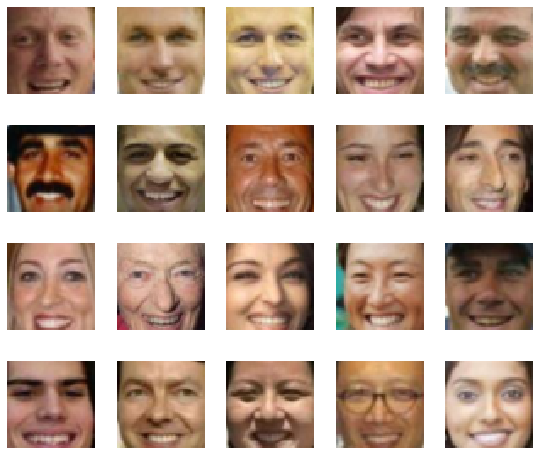

In [28]:
plot_gallery(smiles, IMAGE_H, IMAGE_W, n_row=4, n_col=5)

In [0]:
sad = [243, 271, 292, 313, 329, 684, 746, 907, 995, 
       1051, 1062, 1089, 1099, 1114, 1137, 1319, 1321, 1528, 1534, 1698]

In [30]:
sads=[]
for i in sad:
  sads.append(data[i])


sads = torch.autograd.Variable(torch.FloatTensor(sads)) / 255 
sads = sads.reshape(sads.shape[0], -1)
sads.shape

torch.Size([20, 8112])

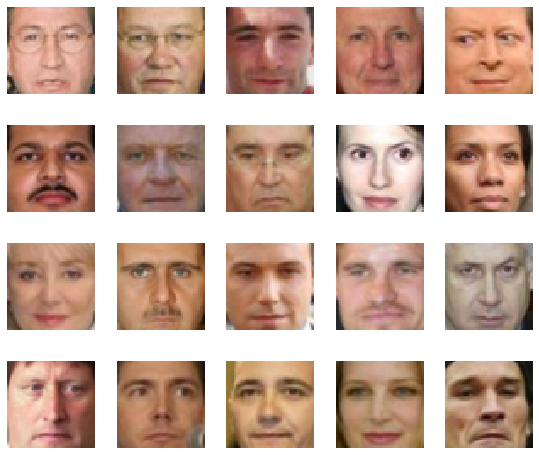

In [31]:
plot_gallery(sads, IMAGE_H, IMAGE_W, n_row=4, n_col=5)

Выделяем латентные вектора с помощью энкодера для тех и этих.

In [0]:
smile_code = autoencoder.encoder(smiles)
sad_code = autoencoder.encoder(sads)

Находим латентный вектор улыбки, вычитая средний латентный вектор грустных из вектора веселых.

In [33]:
sml = torch.zeros(128, dtype=torch.float32)
sd = torch.zeros(128, dtype=torch.float32)

for i in range(20):
  sml += smile_code[i]
  sd += sad_code[i]
sml /= 20
sd /= 20

only_smile = sml - sd
only_smile.shape

torch.Size([128])

Теперь добавляем вектор улыбки к векторам грустненьких и прогоняем новые латентные вектора через декодер.

In [34]:
sads_smile = torch.zeros([20, 128], dtype=torch.float32)
for i in range(20):
  sads_smile[i] = sad_code[i] + only_smile

sads_smile = autoencoder.decoder(sads_smile) 
sads_smile = torch.autograd.Variable(torch.FloatTensor(sads_smile))
sads_smile.shape

torch.Size([20, 8112])

Иногда даже неплохо. (или нет)

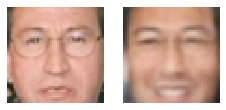

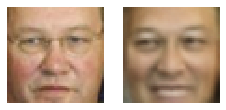

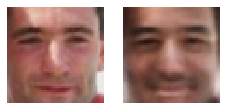

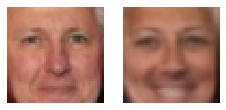

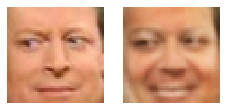

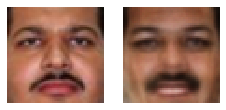

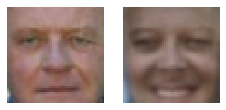

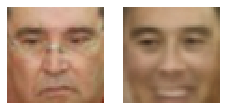

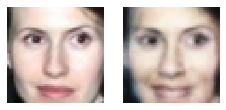

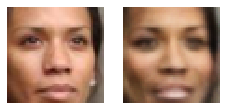

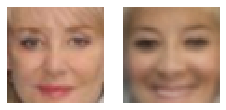

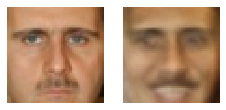

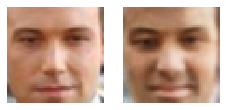

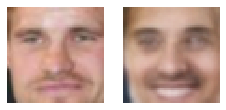

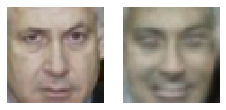

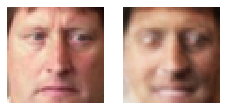

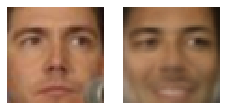

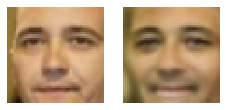

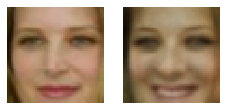

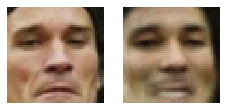

In [35]:
for i in range(20):
  plot_gallery([sads[i], sads_smile[i]], IMAGE_H, IMAGE_W, n_row=1, n_col=2)